# Advanced Model Insights for Regression

This notebook explores additional options for model insights added in the v2.18 release of the DataRobot API that apply specifically to regression models.

## Prerequisites
In order to run this notebook yourself, you will need the following:

- This notebook. If you are viewing this in the HTML documentation bundle, you can download all of the example notebooks and supporting materials from [Downloads](../index.rst).
- A DataRobot API token. You can find your API token by logging into the DataRobot Web User Interface and looking in your `Profile`.

## Preparation

This notebook explores additional options for model insights added in the v2.7 release of the DataRobot API.

Let's start with importing some packages that will help us with presentation (if you don't have them installed already, you'll have to install them to run this notebook).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import datarobot as dr
import numpy as np
from datarobot.enums import AUTOPILOT_MODE

## Configure the Python Client
Configuring the client requires the following two things:

- A DataRobot endpoint - where the API server can be found
- A DataRobot API token - a token the server uses to identify and validate the user making API requests

The endpoint is usually the URL you would use to log into the DataRobot Web User Interface (e.g., https://app.datarobot.com) with "/api/v2/" appended, e.g., (https://app.datarobot.com/api/v2/).

You can find your API token by logging into the DataRobot Web User Interface and looking in your `Profile.`

The Python client can be configured in several ways. The example we'll use in this notebook is to point to a `yaml` file that has the information. This is a text file containing two lines like this:
```yaml
endpoint: https://app.datarobot.com/api/v2/
token: not-my-real-token
```

If you want to run this notebook without changes, please save your configuration in a file located under your home directory called `~/.config/datarobot/drconfig.yaml`.

In [2]:
# Initialization with arguments
# dr.Client(token='<API TOKEN>', endpoint='https://<YOUR ENDPOINT>/api/v2/')

# Initialization with a config file in the same directory as this notebook
# dr.Client(config_path='drconfig.yaml')

# Initialization with a config file located at
# ~/.config/datarobot/dr.config.yaml
dr.Client()

## Create Project with features

Create a new project using the 10K_diabetes dataset. This dataset contains a binary classification on the target `readmitted`.  This project is an excellent example of the advanced model insights available from DataRobot models.

In [3]:
url = 'https://s3.amazonaws.com/datarobot_public_datasets/NCAAB2009_20.csv'
project = dr.Project.create(
    url, project_name="NCAA Men's Basketball 2008-09 season"
)
print('Project ID: {}'.format(project.id))

Project ID: 5dee769c708e5938ec312aa0


In [4]:
# Increase the worker count to your maximum available the project runs faster.
project.set_worker_count(-1)

Project(NCAA Men's Basketball 2008-09 season)

In [5]:
target_feature_name = 'score_delta'
project.set_target(target_feature_name, mode=AUTOPILOT_MODE.QUICK)

Project(NCAA Men's Basketball 2008-09 season)

In [6]:
project.wait_for_autopilot()

In progress: 4, queued: 6 (waited: 0s)
In progress: 4, queued: 6 (waited: 0s)
In progress: 4, queued: 6 (waited: 1s)
In progress: 3, queued: 6 (waited: 1s)
In progress: 2, queued: 5 (waited: 2s)
In progress: 4, queued: 3 (waited: 4s)
In progress: 4, queued: 3 (waited: 7s)
In progress: 2, queued: 0 (waited: 14s)
In progress: 1, queued: 0 (waited: 27s)
In progress: 1, queued: 0 (waited: 47s)
In progress: 4, queued: 12 (waited: 67s)
In progress: 4, queued: 11 (waited: 87s)
In progress: 4, queued: 3 (waited: 107s)
In progress: 2, queued: 0 (waited: 128s)
In progress: 1, queued: 0 (waited: 148s)
In progress: 4, queued: 1 (waited: 168s)
In progress: 0, queued: 0 (waited: 188s)
In progress: 0, queued: 0 (waited: 208s)


In [7]:
models = project.get_models()
model = models[0]
model

Model('TensorFlow Neural Network Regressor')

Let's set some color constants to replicate visual style of the DataRobot residuals chart.

In [8]:
dr_dark_blue = '#08233F'
dr_blue = '#1F77B4'
dr_orange = '#FF7F0E'
dr_red = '#BE3C28'
dr_light_blue = '#3CA3E8'

## Residuals Chart

The residuals chart is only available for non-time aware regression models. It provides a scatter plot showing how predicted values relate to actual values across the data. For large data sets, the value is downsampled to a maximum of 1,000 data points per data source (validation, cross validation, and holdout).

The residuals chart also offers the residual mean (arithmetic mean of predicted values minus actual values) and coefficient of determination, also known as the r-squared value.

In [9]:
residuals = model.get_all_residuals_charts()

In [10]:
print(residuals)

[ResidualChart(holdout), ResidualChart(validation), ResidualChart(crossValidation)]


As you see, there are three charts for this model corresponding to the three data sources. Let's look at the validation data.

In [11]:
validation = residuals[1]
print('Coefficient of determination:', validation.coefficient_of_determination)
print('Residual mean:', validation.residual_mean)

Coefficient of determination: 0.009472645884915032
Residual mean: 0.2240474092818442


Text(0.5,1.04,'Predicted Values vs. Actual Values')

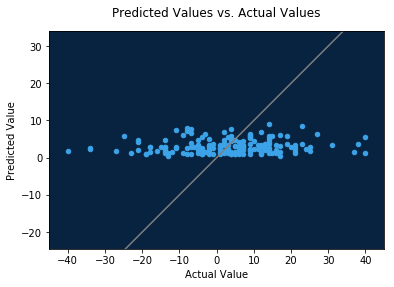

In [12]:
actual, predicted, residual, rows = zip(*validation.data)
data = {'actual': actual, 'predicted': predicted}
data_frame = pd.DataFrame(data)

plot = data_frame.plot.scatter(
    x='actual',
    y='predicted',
    legend=False,
    color=dr_light_blue,
)
plot.set_facecolor(dr_dark_blue)

# define our axes with a minuscule bit of padding
min_x = min(data['actual']) - 5
max_x = max(data['actual']) + 5
min_y = min(data['predicted']) - 5
max_y = max(data['predicted']) + 5

biggest_value = max(abs(i) for i in [min_x, max_x, min_y, max_y])

# plot a diagonal 1:1 line to show the "perfect fit" case
diagonal = np.linspace(-biggest_value, biggest_value, 100)
plt.plot(diagonal, diagonal, color='gray')

plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.axis('equal')
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)

plt.title('Predicted Values vs. Actual Values', y=1.04)

You can also plot residual (predicted minus actual) values against actual values.

Text(0.5,1.04,'Residual Values vs. Actual Values')

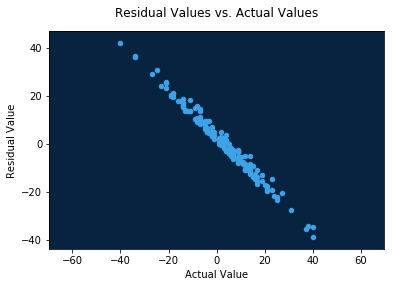

In [13]:
data = {'actual': actual, 'residual': residual}
data_frame = pd.DataFrame(data)

plot = data_frame.plot.scatter(
    x='actual',
    y='residual',
    legend=False,
    color=dr_light_blue,
)
plot.set_facecolor(dr_dark_blue)

# define our axes with a minuscule bit of padding
min_x = min(data['actual']) - 5
max_x = max(data['actual']) + 5
min_y = min(data['residual']) - 5
max_y = max(data['residual']) + 5

plt.xlabel('Actual Value')
plt.ylabel('Residual Value')
plt.axis('equal')
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)

plt.title('Residual Values vs. Actual Values', y=1.04)

In this dataset, these charts indicate that the model tends to under-predict blowouts: games which were won by 20+ points were predicted to be much closer.